In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from typing import ClassVar
from dataclasses import dataclass

import imageio
import sqlite3
import json

import cv2
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np

from sensor_msgs.msg import PointCloud2
from sensor_msgs.msg import Image as ROS_Image
import sensor_msgs_py.point_cloud2 as pc2
from rclpy.serialization import deserialize_message

import matplotlib.pyplot as plt

from PIL import Image
from cv_bridge import CvBridge

from ultralytics import YOLO

from torchvision.models import resnet18 as resnet, ResNet18_Weights
from torchvision import transforms

from sklearn.linear_model import Ridge
from queue import Queue

from src.follow_me.follow_me.tracker import Tracker
# from src.follow_me_yolo.follow_me_yolo import YoloNode


In [3]:
ds = "v1"

conn = sqlite3.connect(f"./{ds}/{ds}_0.db3")
cursor = conn.cursor()

cursor.execute("SELECT * FROM topics")
topic_info = cursor.fetchall()
for topic in topic_info:
    print(topic[1])

/rosout
/events/write_split
/diagnostics
/parameter_events
/velodyne_points
/joint_states
/scan
/tf_static
/velodyne_packets
/camera/camera/color/camera_info
/camera/camera/extrinsics/depth_to_color
/camera/camera/depth/metadata
/camera/camera/depth/camera_info
/camera/camera/depth/image_rect_raw
/camera/camera/color/metadata
/camera/camera/color/image_raw
/odom
/robot_description
/tf
/tracer_status


In [4]:
def get_msg_by_topic(topic_name):
	cursor.execute(f"SELECT * FROM topics WHERE name='{topic_name}'")
	topic_info = cursor.fetchone()
	
	if not topic_info:
		print(f"Topic '{topic_name}' not found.")
		return None
	
	topic_id = topic_info[0]  # 'id' is the first column in topics
	
	# Get all messages for that topic
	cursor.execute("SELECT * FROM messages WHERE topic_id = ?", (topic_id,))
	messages = cursor.fetchall()
	
	return messages

rgb_msgs = get_msg_by_topic("/camera/camera/color/image_raw")
info_msgs = get_msg_by_topic("/camera/camera/color/camera_info")
depth_msgs = get_msg_by_topic("/camera/camera/depth/image_rect_raw")

In [5]:
model = YOLO("yolo11n-pose.pt")
model.eval()

bridge = CvBridge()

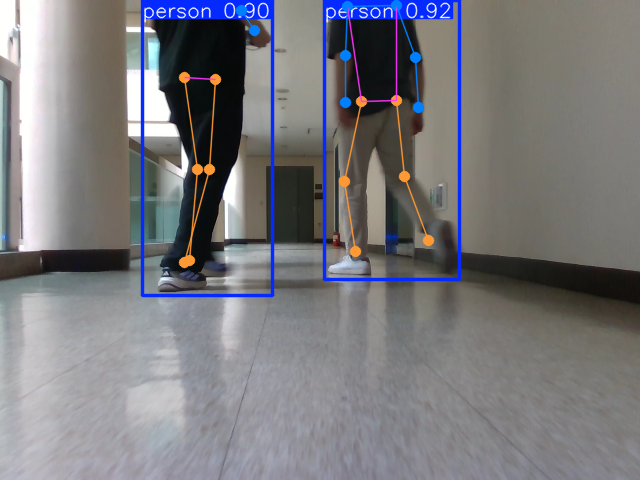

In [ ]:
# idx = 1398

idx = 1730


msg_id, topic_id, timestamp, rgb_msg = rgb_msgs[idx]
msg_id, topic_id, timestamp, info_msg = info_msgs[idx]
msg_id, topic_id, timestamp, depth_msg = depth_msgs[idx]

rgb_msg = deserialize_message(rgb_msg, ROS_Image)
image = bridge.imgmsg_to_cv2(rgb_msg, "bgr8")  # (480, 848, 3)

depth_msg = deserialize_message(depth_msg, ROS_Image)
depth_image = bridge.imgmsg_to_cv2(depth_msg, "passthrough")  # (480, 848)
_depth_image = cv2.resize(depth_image, (image.shape[1], image.shape[0]))
results = model(
    image, [448, 256],
    conf=0.5,
    verbose=False
)
result = list(results)[0]
result.show()

xywh = result.boxes.xywh.cpu().numpy()
conf = result.keypoints.conf.cpu().numpy()
xy = result.keypoints.xy.cpu().numpy()
_xy = np.trunc(xywh[:, :2]).astype(int)
positions = _depth_image[_xy[:, 1], _xy[:, 0]]

In [41]:
len(result)

2

In [ ]:
positions

In [ ]:
conf

In [ ]:
_xy

In [ ]:
image.shape, depth_image.shape, xy.shape, xy.dtype

In [ ]:
xywh.shape, conf.shape, xy.shape

In [ ]:
def draw_img(target_id, image, result):
	annotated = image.copy()
	for idx, (bbox, conf) in enumerate(zip(result.boxes.xywh, result.boxes.conf)):
		x, y, w, h = map(int, bbox)
		
		cv2.rectangle(annotated, 
			(int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)),
			(255, 0, 0) if target_id==idx else (0, 255, 0), 2
		)
		# cv2.putText(annotated, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

	return annotated

bridge = CvBridge()
tracker = Tracker((256, 448))

conf_threshold = .6

is_following = False
frames = []
# for idx in range(450, 451):
# for idx in range(785, 786):
# for idx in range(1800, 1810):
for idx in range(1700, 2100):
# for idx in range(1550, len(messages)):
	msg_id, topic_id, timestamp, data = messages[idx]
	rgb_image = deserialize_message(data, ROS_Image)
	cv_image = bridge.imgmsg_to_cv2(rgb_image, desired_encoding='bgr8')
	h, w = cv_image.shape[:2]

	results = model(
		cv_image,
		conf=conf_threshold,
		verbose=False,
	)
	result = results[0].cpu()
	# result.show()

	if len(result.boxes) == 0:
		frames.append(cv_image)
		continue
	if not torch.any(result.keypoints.conf > 0.5):
		frames.append(cv_image)
		continue
	
	bboxes = result.boxes.xywh.numpy()
	kpts = result.keypoints.xy.numpy()
	confs = result.keypoints.conf.numpy()
	# print(len(bboxes), len(kpts))
	# print(result.boxes.conf.numpy())
	
	all_features, visible_part = tracker.process_crop(
		cv_image, bboxes, kpts, confs
	)
	
	if not is_following:
		is_following = True
		xy = bboxes[:, :2]
		dist = xy - np.array([w/2, h/2])
		dist = np.abs(dist).sum(-1)
		target_id = np.argmin(dist)
	else:
		target_id = tracker.identify(
			all_features.cpu().detach(),
			visible_part.cpu().detach(),
			threshold=0.5
		)
		if target_id is None: target_id = -1

	if target_id != -1:
		tracker.update(target_id, all_features, visible_part)
	# tracker.identify(
	# 	all_features.cpu().detach(),
	# 	visible_part.cpu().detach()
	# )
	annotated = draw_img(target_id, cv_image, result)
	frames.append(annotated)


In [ ]:
imageio.mimsave("./detections.gif", frames, fps=30)